In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import math

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

In [53]:
df = pd.read_csv("Fish.csv")
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


The dataset consits in 7 features and 159 observations. "Weight" is the target variable. All input  but Species are numerical variables

In [54]:
df['Species'].value_counts()


Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

For different species, the number of observations is very low. This can introduce imbalance in the model, since there are classes with very low representation

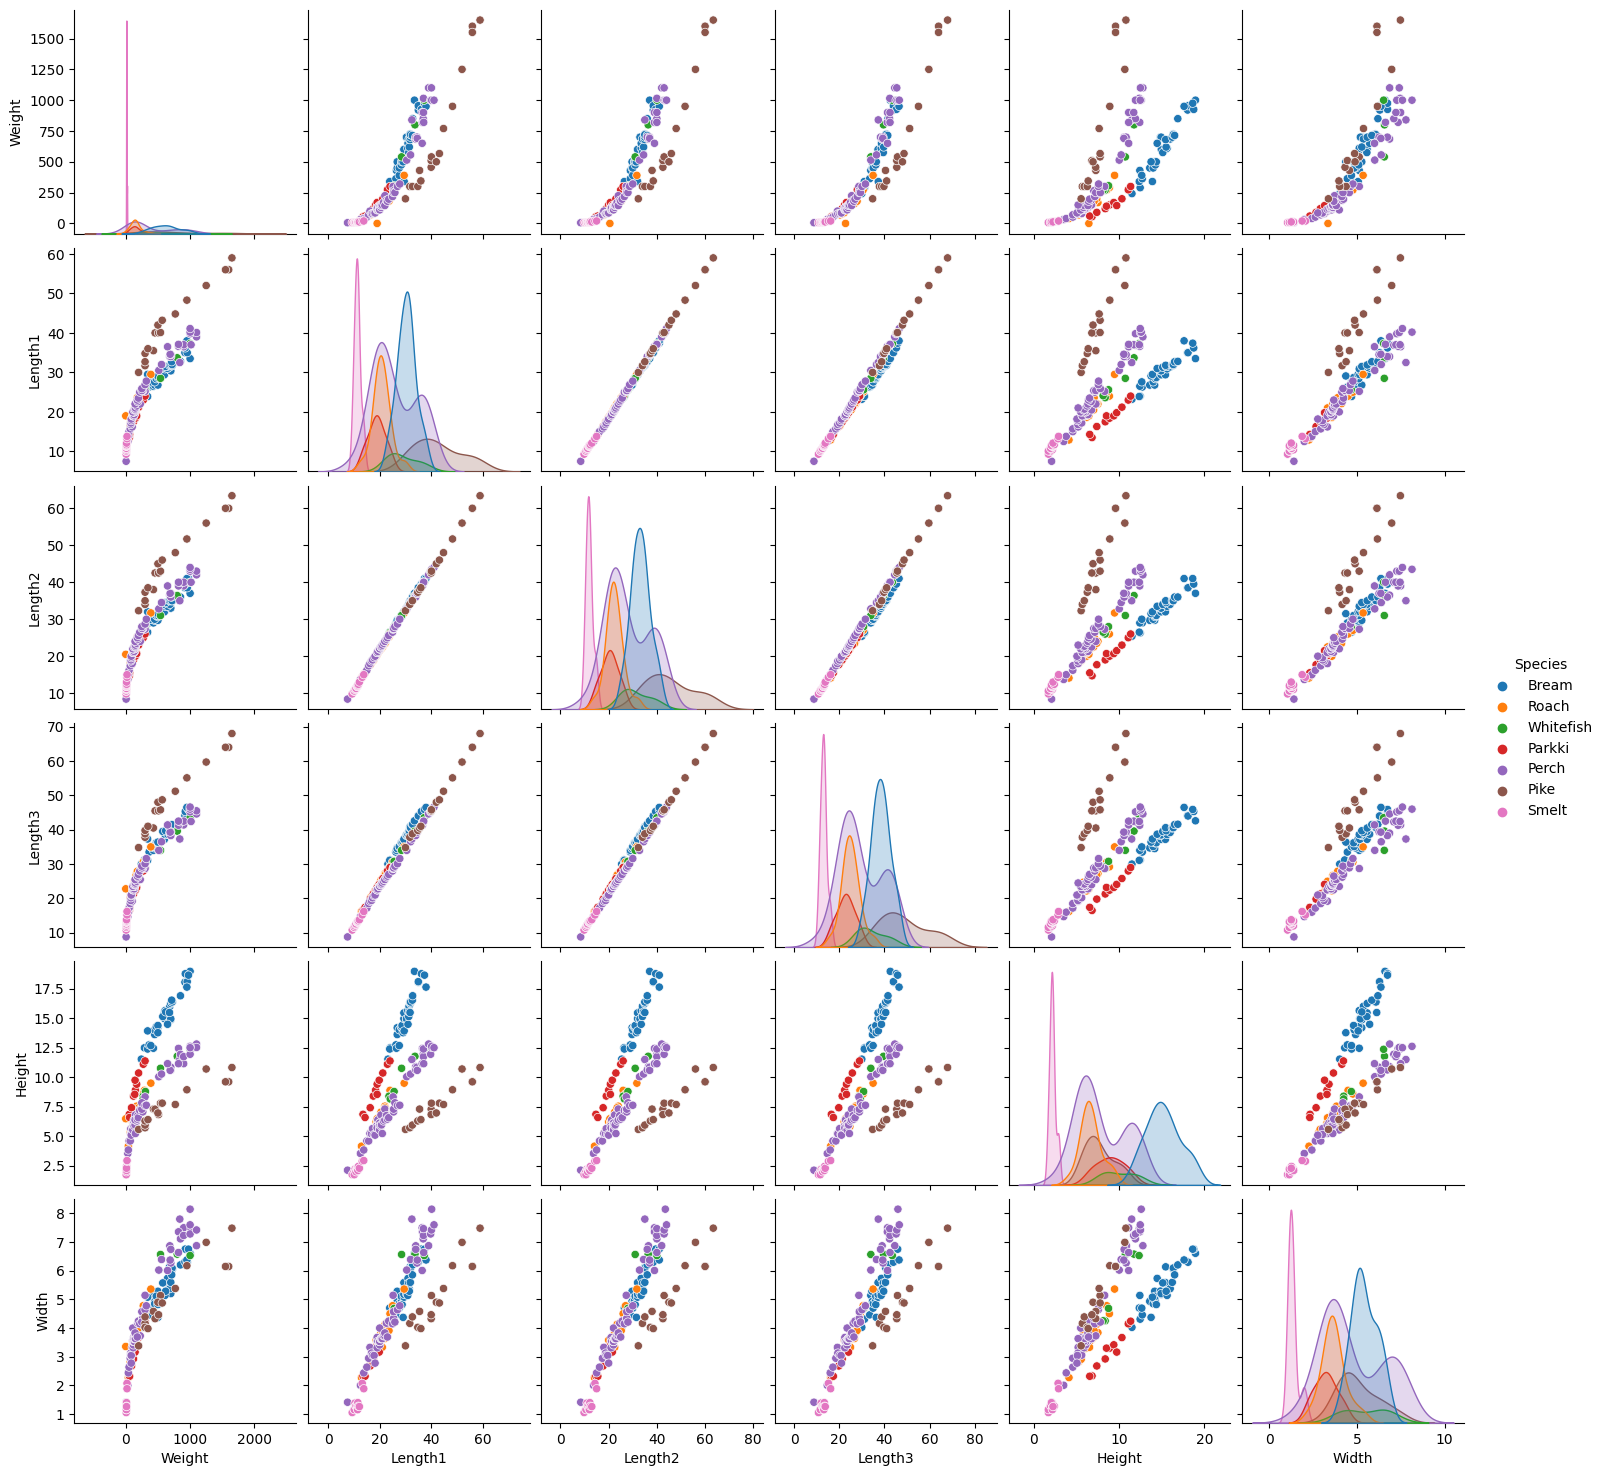

In [55]:
sns.pairplot(df, hue='Species')

In the pairplot it is observed the strong multicollinearity present among features as Lenth 1, 2 and 3, meaning that by knowing one length, one can know all the others, thus, these features are not adding information to the model and can be dropped. These results can be better contrasted in the following confusion matrix: 

In [56]:
correlation_matrix = df.drop(columns='Species').corr()
correlation_matrix

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.915712,0.918618,0.923044,0.724345,0.886507
Length1,0.915712,1.000000,0.999517,0.992031,0.625378,0.867050
Length2,0.918618,0.999517,1.000000,0.994103,0.640441,0.873547
Length3,0.923044,0.992031,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.625378,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.867050,0.873547,0.878520,0.792881,1.000000


Due to the strong multicollinearity present, Length2 and Length3 are dropped from the dataset

In [57]:
df.drop(columns=['Length2', 'Length3'], inplace=True)
df = df[df['Weight'] !=0]

<Axes: >

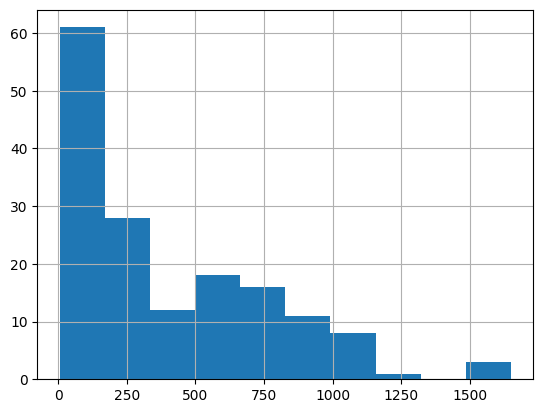

In [58]:
df.Weight.hist()

Making the target normally distributed will lead to better results. If our target is not normally distributed, it is possible to apply a transformation to it and then fit our regression to predict the transformed values.
Since the target is non-parametric, no transformation is need, since it is far from being normally distributed.

<Axes: xlabel='Species', ylabel='Length1'>

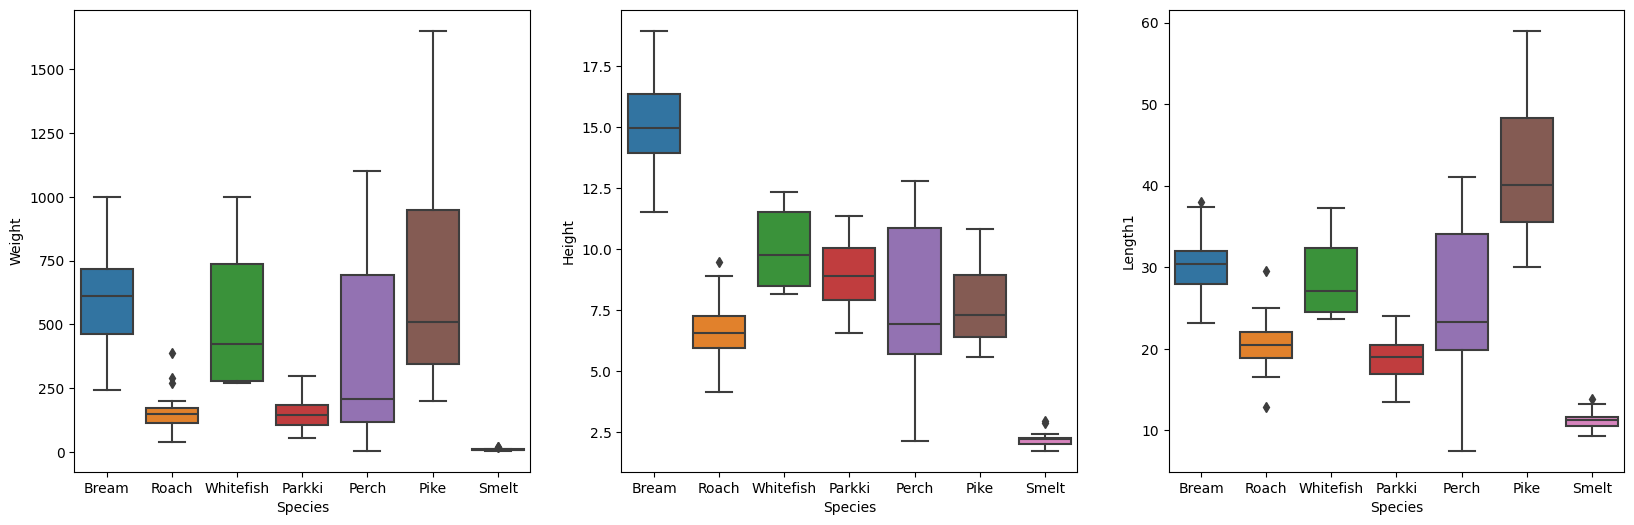

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
sns.boxplot(data=df, x="Species", y="Weight", ax=ax1)
sns.boxplot(data=df, x="Species", y="Height", ax=ax2)
sns.boxplot(data=df, x="Species", y="Length1", ax=ax3)

In [60]:
df.describe()

,Weight,Length1,Height,Width
count,158.000000,158.000000,158.000000,158.000000
mean,400.847468,26.293038,8.986790,4.424232
std,357.697796,10.011427,4.295191,1.689010
min,5.900000,7.500000,1.728400,1.047600
25%,121.250000,19.150000,5.940600,3.398650
50%,281.500000,25.300000,7.789000,4.277050
75%,650.000000,32.700000,12.371850,5.586750
max,1650.000000,59.000000,18.957000,8.142000


In the boxplot it is observed how different the variables are according to the spici. Whereas smelt fishes are short, small and light, bream are large, weighted and larges. Additionally, it is seen that there are a few outliers. However, there are some unconsistencies in the dataset since some values are wighted 0, and this cannot be possible. Therefore those values are removed.

In [61]:
df =df[df['Weight'] != 0]

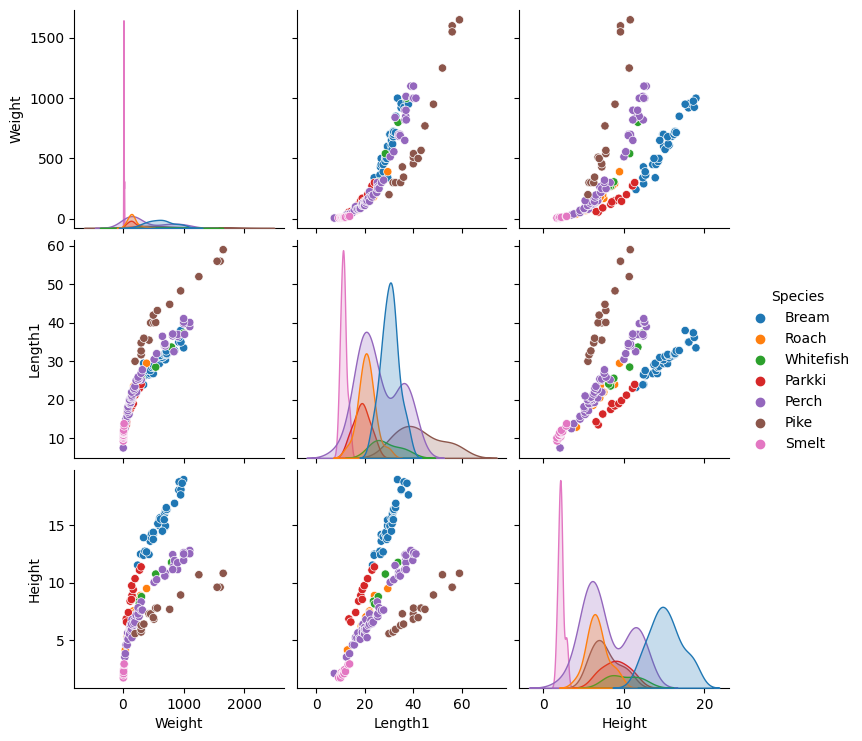

In [62]:
sns.pairplot(df[['Weight', 'Length1', 'Height', 'Species']], hue="Species")

his last pairplot provides the most useful information. It reveals the relationship between weight and the other parameters, which is actually the behavior that the model aims to predict. The exponential growth present can be mitigated and fitted to a linear regression by logarithmically transforming the inputs

# First iteration: LR for just 1 species

To get started, as has been observed, the spices play a crucial role because they are grouped into clusters. Therefore, to begin, a single spice has been selected to implement a simple linear regression

In [63]:
perch_df = df[df['Species'] == 'Perch'].drop(columns=['Species']).reset_index().drop(columns=['index'])
perch_df.head()

,Weight,Length1,Height,Width
0,5.9,7.5,2.1120,1.4080
1,32.0,12.5,3.5280,1.9992
2,40.0,13.8,3.8240,2.4320
3,51.5,15.0,4.5924,2.6316
4,70.0,15.7,4.5880,2.9415


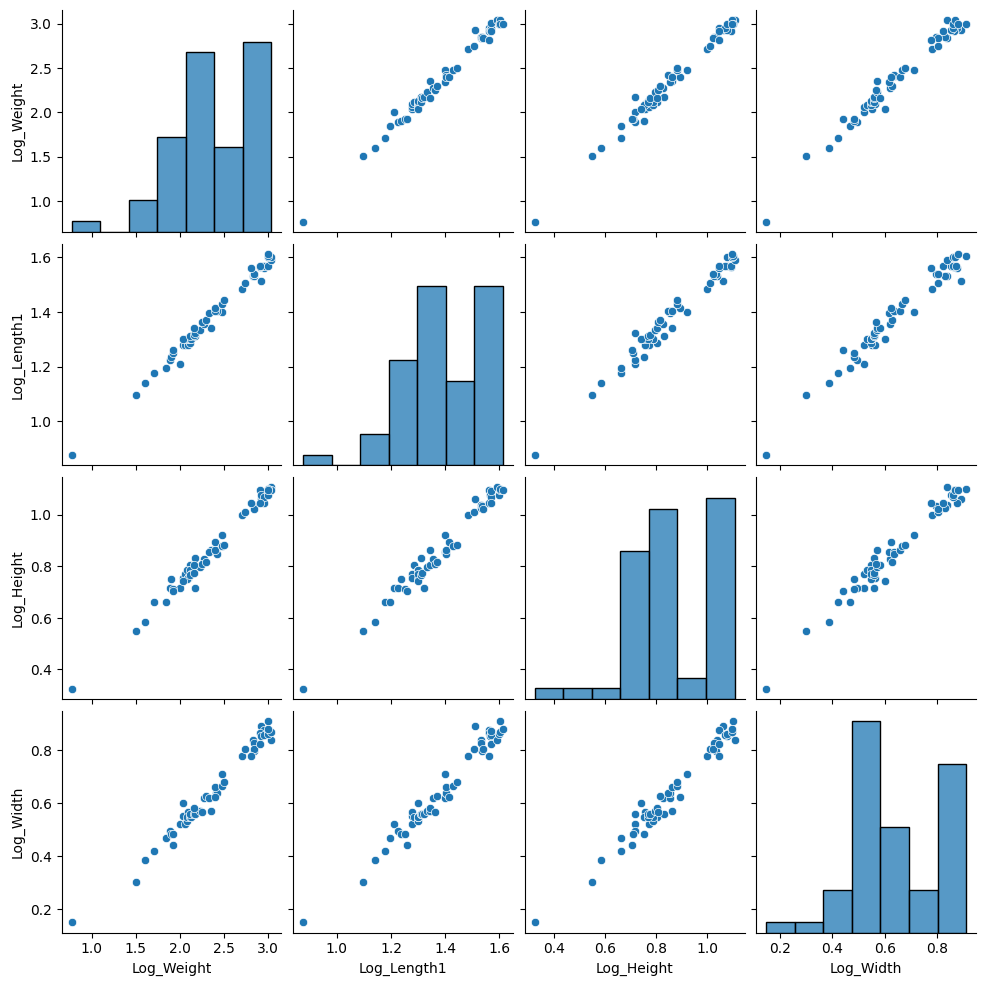

In [51]:
sns.pairplot(perch_df)

In the pairplot, quadratic and linear regression are observed. Let's start by fitting a linear regression. Rightafter, polynominalfeatures will add more degrees to the model, and the results are going to be compared.

In [66]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())])


X = perch_df.drop(columns=['Weight'])
y=perch_df['Weight']

kf = KFold(n_splits=3, shuffle=True)

r2_training = []
rmse_training = []
r2_test = []
rmse_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    rmse_training.append(mean_absolute_error(y_train, y_pred_train))
    r2_training.append(r2_score(y_train, y_pred_train))
    rmse_test.append(mean_absolute_error(y_test, y_pred_test))
    r2_test.append(r2_score(y_test, y_pred_test))

print(f'MAE training: {rmse_training}, in test: {rmse_test}')
print(f'R2 training: {r2_training}, in test: {r2_test}')

MAE training: [57.444302591594905, 56.451868521875184, 62.708144961014284], in test: [83.00548652406327, 86.74515864471914, 62.724598841338235]
R2 training: [0.9604305145171971, 0.9428989979529494, 0.9344444327692077], in test: [0.8057142541146405, 0.9096715795133138, 0.953595388171186]


this first model is built using a pipeline that first standardizes the values and then fits the linear regression to estimate the parameters. Additionally, k-fold cross-validation with three splits is implemented to avoid overfitting. The error metrics selected for this case are MAE and R^2. Since this fish class has the most variance, as seen in the boxplot in the previous section, the expected results may be less accurate than for other species. However, adding more data will improve the model's performance. The training error and the test error present similar results, so there is no overfitting. Finally, the R^2 close to 1 indicates that a significant portion of the variance is explained by the model.

In [22]:
X = perch_df.drop(columns=['Weight'])
y=perch_df['Weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

mae: 68.10338812833567 and r2 : 0.9161045975024179
Coefficients (weights) of the polynomial regression model:
[ 71.20734855 179.704176    75.12304957]

Intercept of the polynomial regression model:
393.84615384615387


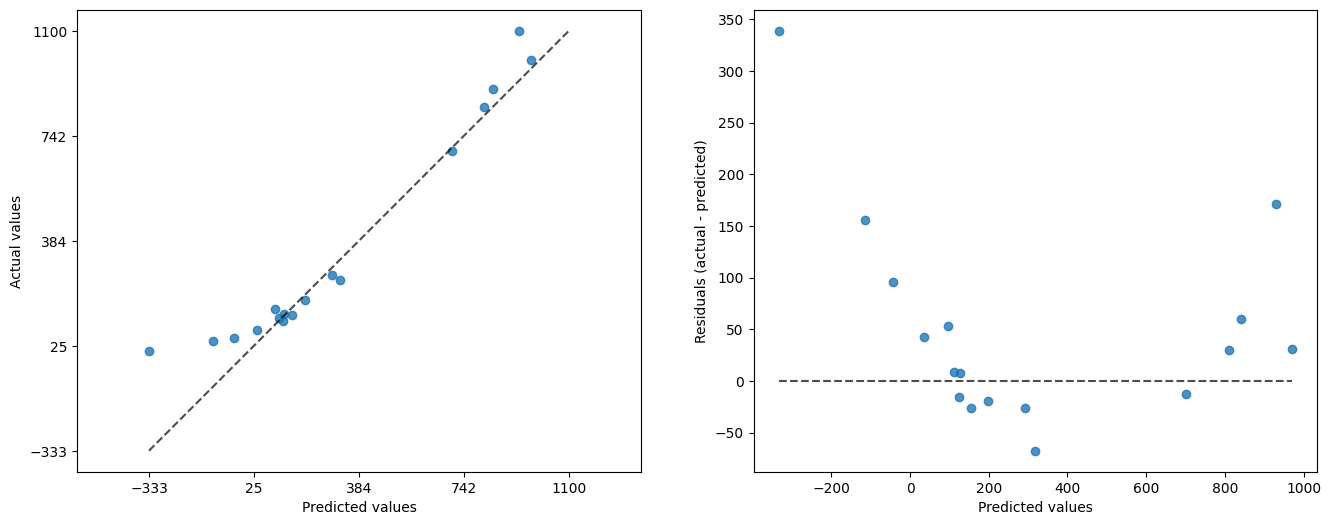

In [23]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'mae: {mae} and r2 : {r2}')

coefficients = pipe.named_steps['lr'].coef_
intercept = pipe.named_steps['lr'].intercept_

print("Coefficients (weights) of the polynomial regression model:")
print(coefficients)
print("\nIntercept of the polynomial regression model:")
print(intercept)


f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, kind= "actual_vs_predicted", ax=ax1)
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, ax=ax2)

The first linear regression performs correctly, given the short dataset presented, as well as the high variance for this species. The residuals show how much the predicted values differ from the real ones. The actual-vs-predicted plot gives an overall idea of the scale of the errors. The MAE is 60, and the coefficients represent the slopes of the features; the greater the coefficient, the more important the feature is. Actually, it is observed that there is a feature that outperforms the others, which is the Height

mae: 31.997210921403777 and r2 : 0.9833551490161458
Coefficients (weights) of the polynomial regression model:
[ 119.3826493    83.04881757  104.69496768  117.22291375 -241.12751353
   82.89002144  504.0440367  -660.69589047  277.15500844]

Intercept of the polynomial regression model:
295.7595853671835


<Figure size 1600x600 with 0 Axes>

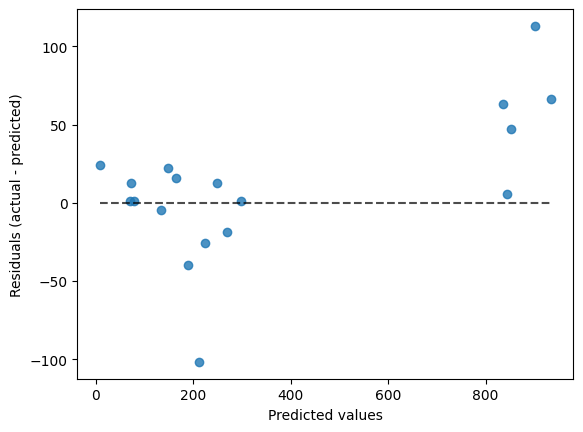

In [67]:
pipe = Pipeline([("ss", StandardScaler()),
                 ("poly", PolynomialFeatures(include_bias=False, degree=2)),
                 ("lr", LinearRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mae: {mae} and r2 : {r2}')

coefficients = pipe.named_steps['lr'].coef_
intercept = pipe.named_steps['lr'].intercept_

print("Coefficients (weights) of the polynomial regression model:")
print(coefficients)
print("\nIntercept of the polynomial regression model:")
print(intercept)

plt.figure(figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

In this other model, the performance is much more accurate, with a MAE equal to 17. It is observed that more coefficients have been added due to the implementation of a second-degree model. Therefore, it can be concluded that polynomial features increase performance. The results with a degree equal to 3 were less accurate.

## Standard model

In [68]:
df.head(6)

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340
5,Bream,450.0,26.8,13.6024,4.9274


In [69]:
# ELogarithmic transformation
df['Log_Weight'] = np.log10(df['Weight'])
df['Log_Length1'] = np.log10(df['Length1'])
df['Log_Height'] = np.log10(df['Height'])
df['Log_Width'] = np.log10(df['Width'])
df_bck = df.copy()
df.drop(columns=['Weight', 'Length1', 'Height', 'Width'], inplace=True)

In [70]:
df

,Species,Log_Weight,Log_Length1,Log_Height,Log_Width
0,Bream,2.383815,1.365488,1.061452,0.604226
1,Bream,2.462398,1.380211,1.096215,0.634034
2,Bream,2.531479,1.378398,1.092643,0.671737
3,Bream,2.559907,1.419956,1.104828,0.648896
4,Bream,2.633468,1.423246,1.094960,0.710456
...,...,...,...,...,...
154,Smelt,1.086360,1.060698,0.320229,0.144138
155,Smelt,1.127105,1.068186,0.385606,0.103462
156,Smelt,1.086360,1.082785,0.357363,0.098920
157,Smelt,1.294466,1.120574,0.458305,0.315382


mae: 28.757606611087066 and r2 : 0.9962969049218038


<Figure size 1600x600 with 0 Axes>

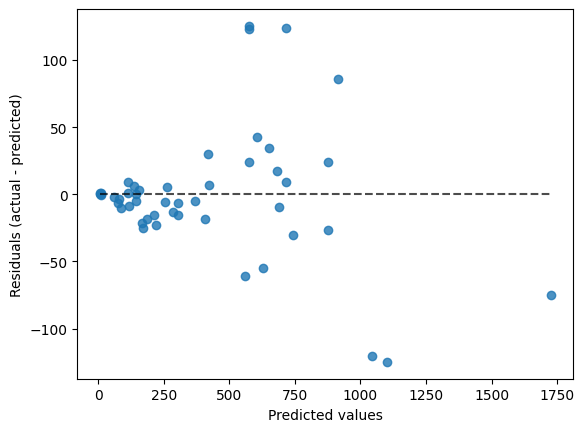

In [87]:
X = df.drop(columns=['Log_Weight'])
y= df['Log_Weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ct = ColumnTransformer([
    ("numericals", StandardScaler(), X_train.select_dtypes(include=['float64']).columns),
    ("categories", OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)
])

pipeline = Pipeline(steps=[('preprocessor', ct),
                           ('regressor', LinearRegression())])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

inverse_y_pred = [10**x for x in y_pred]
inverse_y_test = [10**x for x in y_test]

mae = mean_absolute_error(inverse_y_test, inverse_y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mae: {mae} and r2 : {r2}')

plt.figure(figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true= np.array(inverse_y_test), y_pred=np.array(inverse_y_pred))

Low error when we have more information. This model captures better lower errors than large ones. If the species form clusters, it will suggest that a model is needed for each species.

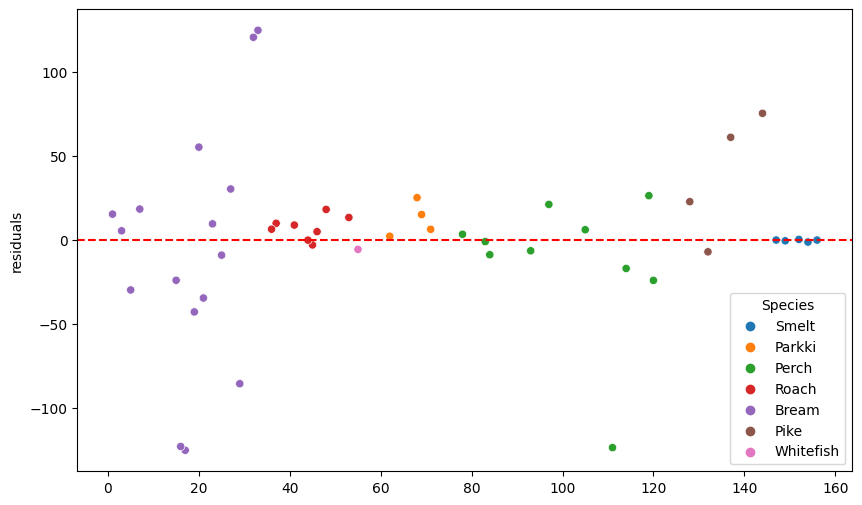

In [109]:
data_dic = {
    'ypred' : inverse_y_pred,
    'ytest' : inverse_y_test,
    'Species' : X_test['Species'] 
}
predictions = pd.DataFrame(data_dic)

# predictions = pd.DataFrame(data_dic).reset_index().drop(columns=["index"])
predictions['residuals'] = predictions['ypred']-predictions["ytest"]
plt.figure(figsize=(10,6))

sns.scatterplot(data=predictions, x=predictions.index, y="residuals", hue= "Species")
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals Line')

This results clustered show that a single model for each species is required